In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch, time, os, sys
import numpy as np
import scipy.integrate, scipy.ndimage
from nn_model import MLP
from hnn import hnn
from data import get_dataset, get_orbit, sjs, potential_energy, kinetic_energy, total_energy, get_nn_orbit


def get_args():
    return {
        'nonlinearity': 'tanh', 'hidden_dim': 300, 'input_dim': 12, 'learning_rate': 0.001, 'batch_size': 5000,
        'total_steps': 8000, 'print_every': 1000, 'name': 'sjs', 'verbose': True, 'field_type': 'solenoidal',
        'seed': 0, 'save_dir': '/home/kevin/code/project/planetary'}


class ObjectView(object):
    def __init__(self, d): self.__dict__ = d



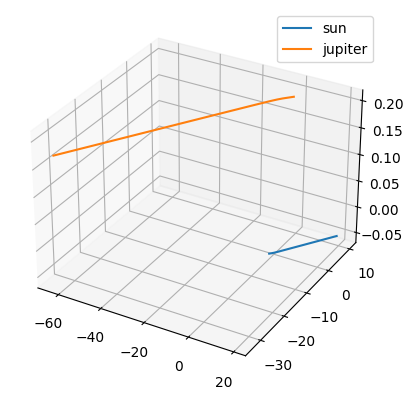

In [3]:
args = ObjectView(get_args())
np.random.seed(0)
state = sjs()

import rebound

sim = rebound.Simulation()
sim.units = ('yr', 'AU', 'Msun')
#add state to sim
sim.add(m=state[0][0], x=state[0][1], y=state[0][2], z=state[0][3], vx=state[0][4], vy=state[0][5], vz=state[0][6])
sim.add(m=state[1][0], x=state[1][1], y=state[1][2], z=state[1][3], vx=state[1][4], vy=state[1][5], vz=state[1][6])
#sim.add(m=state[2][0], x=state[2][1], y=state[2][2], z=state[2][3], vx=state[2][4], vy=state[2][5], vz=state[2][6])
sim.move_to_com()
sim.integrator = "whfast"
sim.dt = 0.01

t = np.linspace(0, 50, 1000)
su = np.zeros((len(t), 3))
j = np.zeros((len(t), 3))
s = np.zeros((len(t), 3))
for i, time in enumerate(t):
    sim.integrate(time)
    su[i] = [sim.particles[0].x, sim.particles[0].y, sim.particles[0].z]
    j[i] = [sim.particles[1].x, sim.particles[1].y, sim.particles[1].z]
    #s[i] = [sim.particles[2].x, sim.particles[2].y, sim.particles[2].z]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(su[:, 0], su[:, 1], su[:, 2], label='sun')
ax.plot(j[:, 0], j[:, 1], j[:, 2], label='jupiter')
#ax.plot(s[:, 0], s[:, 1], s[:, 2], label='saturn')

ax.legend()
plt.show()



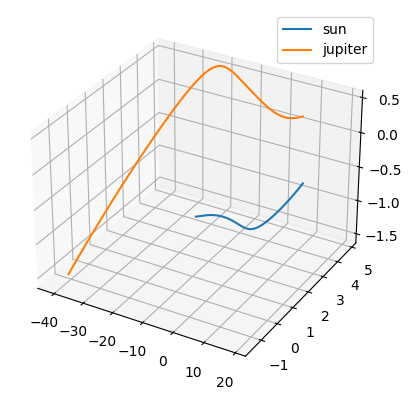

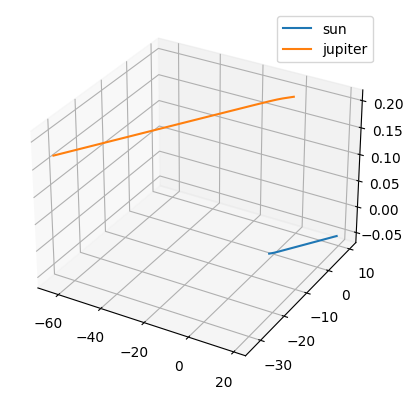

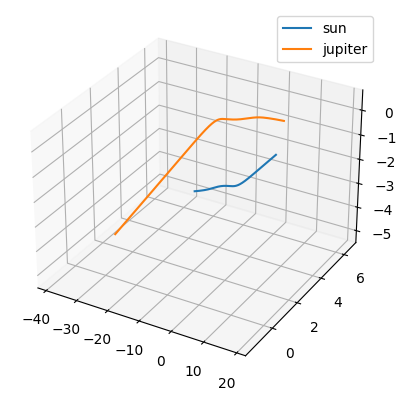

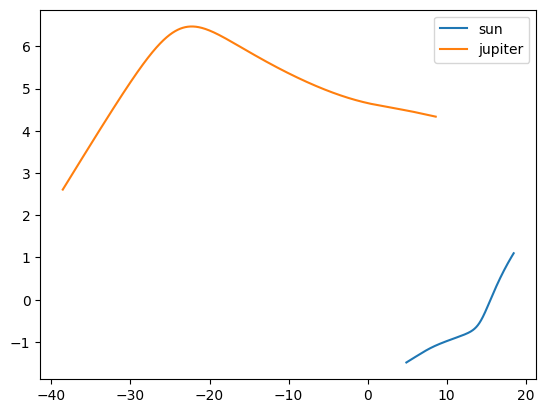

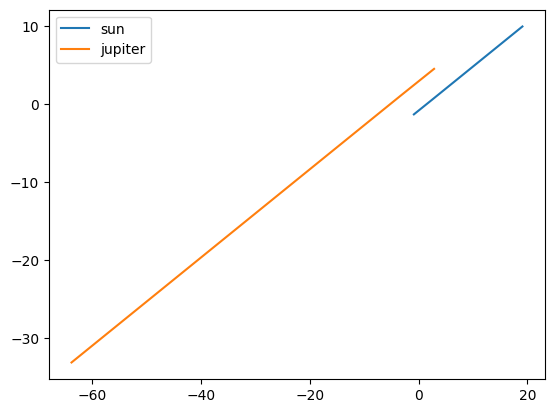

In [12]:
lw = 3  #linewidth
fs = 9
ts = 15
tpad = 7
ls = 12


def load_model(args):
    output_dim = 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = hnn(args.input_dim, differentiable_model=nn_model, field_type=args.field_type)
    label = 'hnn'
    path = '{}/{}_{}.pt'.format(args.save_dir, args.name, label)
    model.load_state_dict(torch.load(path))
    return model


hnn_model = load_model(args)


def model_update(t, state, model):
    state = state.reshape(-1, 7)

    deriv = np.zeros_like(state)
    np_x = state[:, 1:]  # drop mass
    np_x = np_x.T.flatten()[None, :]
    x = torch.tensor(np_x, requires_grad=True, dtype=torch.float32)
    dx_hat = model.time_deriv(x)
    deriv[:, 1:] = dx_hat.detach().data.numpy().reshape(6, 2).T
    return deriv.reshape(-1)


np.random.seed(0)
t_points = 1000
t_span = [0, 50]
state = sjs()

orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span)

update_fn = lambda t, y0: model_update(t, y0, hnn_model)

hnn_orbit, settings = get_nn_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)

# plot 3d hnn_orbit
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, planet in enumerate(hnn_orbit):
    ax.plot(planet[1], planet[2], planet[3], label={'0': 'sun', '1': 'jupiter', '2': 'saturn'}[str(i)])
ax.legend()
plt.show()

# plot 3d orbit
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, planet in enumerate(orbit):
    ax.plot(planet[1], planet[2], planet[3], label={'0': 'sun', '1': 'jupiter', '2': 'saturn'}[str(i)])
ax.legend()
plt.show()

#manually do the orbit integration with model_update
oorbit = np.zeros((len(t), 2, 7))
oorbit[0] = state
for i in range(1, len(t)):
    d = model_update(t[i - 1], oorbit[i - 1], hnn_model)
    d.resize((2, 7))

    #add on the keplarian orbit from a sun in the middle
    dd = np.zeros_like(d)
    m = 1
    x, y, z = 0, 0, 0
    for j in range(2):
        r = np.sqrt((oorbit[i - 1][j][0] - x) ** 2 + (oorbit[i - 1][j][1] - y) ** 2 + (oorbit[i - 1][j][2] - z) ** 2)
        dd[j][4] = -m * (oorbit[i - 1][j][0] - x) / r ** 3
        dd[j][5] = -m * (oorbit[i - 1][j][1] - y) / r ** 3
        dd[j][6] = -m * (oorbit[i - 1][j][2] - z) / r ** 3

    d += dd

    oorbit[i] = oorbit[i - 1] + d * (t_span[1] - t_span[0]) / t_points

#graph the orbit
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# reshape it from time, planet, xyz to planet, xyz, time
oorbit = np.swapaxes(oorbit, 0, 1)
oorbit = np.swapaxes(oorbit, 1, 2)
for i, planet in enumerate(oorbit):
    ax.plot(planet[1], planet[2], planet[3], label={'0': 'sun', '1': 'jupiter', '2': 'saturn'}[str(i)])
ax.legend()
plt.show()

#plot it in 2d
fig = plt.figure()
ax = fig.add_subplot(111)
for i, planet in enumerate(oorbit):
    ax.plot(planet[1], planet[2], label={'0': 'sun', '1': 'jupiter', '2': 'saturn'}[str(i)])
ax.legend()
plt.show()

#real one in 2d
fig = plt.figure()
ax = fig.add_subplot(111)
for i, planet in enumerate(orbit):
    ax.plot(planet[1], planet[2], label={'0': 'sun', '1': 'jupiter', '2': 'saturn'}[str(i)])
ax.legend()
plt.show()




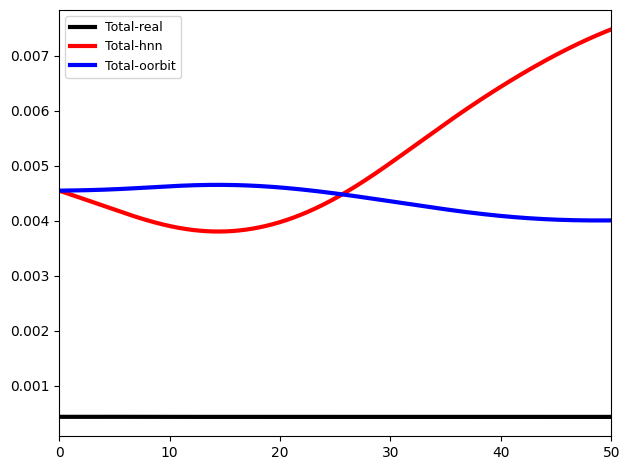

<Figure size 640x480 with 0 Axes>

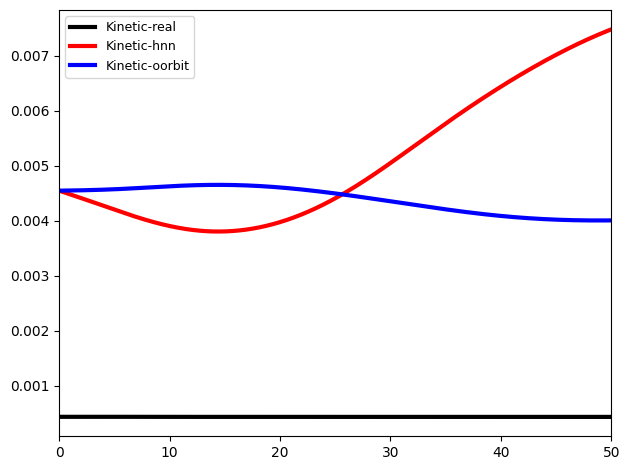

<Figure size 640x480 with 0 Axes>

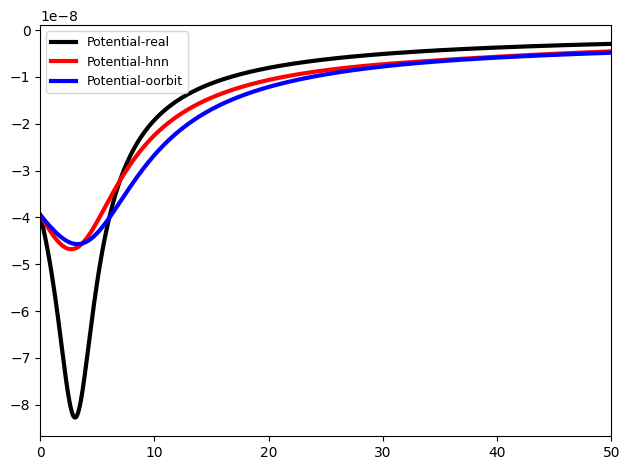

In [8]:
# graph all energies
lw = 3  #linewidth
fs = 9
ts = 15
tpad = 7
ls = 12

plt.figure()
plt.plot(settings['t_eval'], total_energy(orbit), 'k-', label='Total-real', linewidth=lw)
plt.plot(settings['t_eval'], total_energy(hnn_orbit), 'r-', label='Total-hnn', linewidth=lw)
plt.plot(settings['t_eval'], total_energy(oorbit), 'b-', label='Total-oorbit', linewidth=lw)

plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
plt.tight_layout();
plt.show()

# separate graph for kinetic
plt.figure()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(settings['t_eval'], kinetic_energy(orbit), 'k-', label='Kinetic-real', linewidth=lw)
ax.plot(settings['t_eval'], kinetic_energy(hnn_orbit), 'r-', label='Kinetic-hnn', linewidth=lw)
ax.plot(settings['t_eval'], kinetic_energy(oorbit), 'b-', label='Kinetic-oorbit', linewidth=lw)
ax.legend(fontsize=fs)
ax.set_xlim(*settings['t_span'])
plt.tight_layout();
plt.show()

# separate graph for potential
plt.figure()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(settings['t_eval'], potential_energy(orbit), 'k-', label='Potential-real', linewidth=lw)
ax.plot(settings['t_eval'], potential_energy(hnn_orbit), 'r-', label='Potential-hnn', linewidth=lw)
ax.plot(settings['t_eval'], potential_energy(oorbit), 'b-', label='Potential-oorbit', linewidth=lw)
ax.legend(fontsize=fs)
ax.set_xlim(*settings['t_span'])
plt.tight_layout();
plt.show()


